In [1]:
import numpy as np
import pandas as pd
import pickle

import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split


In [2]:
df = pd.read_csv("/Users/admin/Downloads/parklane_combined_edited.csv", index_col='timestamp')
print('Unfiltered row of dataframe is {}'.format(len(df)))

Unfiltered row of dataframe is 727657


### This notebook focus will be on predicting ch_sysef using various features and some selections of models

In [7]:
# filter where hr or hb is  not 0
df = df[(df['sys_hr'] != 0) | (df['sys_hb'] != 0)]
df = df[(df['h_chwst'] >=5) & (df['h_chwst'] <=20)]
df = df[(df['h_chwrt'] >=5) & (df['h_chwrt'] <=25)]
df = df[(df['pchwp_1_kw'] >=1.2) & (df['pchwp_1_kw'] <=5)]
# unsure of pchwp_2 kw filtering
#df = df[(df['pchwp_2_kw'] >=1.2) & (df['pchwp_2_kw'] <=5)]
df = df[(df['h_chwf'] >= 0) & (df['h_chwf'] <= 1500)]
df = df[(df['cwp_1_kw'] > 0) & (df['cwp_1_kw'] <=25)]
df = df[(df['cwp_2_kw'] > 0) & (df['cwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >0) & (df['h_chwf'] <=1500)]
df = df[(df['h_cwst']>=20) & (df['h_cwst']<=32)]
df = df[(df['h_cwrt']>=20) & (df['h_cwrt']<=40)]
df = df[(df['ch_1_kwe']>=2) & (df['ch_1_kwe']<=350)]
df = df[(df['ch_2_kwe']>=2) & (df['ch_2_kwe']<=350)]
df = df[(df['ct_1_kw']>0) & (df['ct_1_kw']<=15)]
df = df[(df['ct_2_kw']>0) & (df['ct_2_kw']<=15)]
df = df[(df['sys_cl']>=200) & (df['sys_cl']<=500)]
df = df[(df['sys_hr']>0) & (df['sys_hr']<=1000)]
df = df[(df['sys_kw']>0) & (df['sys_kw']<=400)]
fil_df = df[(df['ch_sysef']>=0.4) & (df['ch_sysef']<=0.7)]

# replace NaN values with 0? median imputation
fil_df = fil_df.fillna(0)

# creating Lift Column, Lift: [h_cwrt-h_chwst]
fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']
fil_df = fil_df[(fil_df['ct_tot_kw']>=3.5) & (fil_df['ct_tot_kw']<=17)]

print("total number of rows after filter is {}".format(len(fil_df)))

total number of rows after filter is 67277


In [5]:
# selecting related features only
ch_sysef_df = fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw']]

ch_sysef_df.head(5)

,ch_sysef,lift,sys_cl,ct_tot_kw
timestamp,,,,
3/12/2023 10:43,0.430923,14.784712,278.134430,7.136
3/12/2023 10:44,0.511065,15.728039,304.647736,7.120
3/12/2023 10:45,0.511650,17.931899,354.165314,7.024
3/12/2023 10:46,0.497447,19.139454,352.233795,7.056
3/12/2023 10:47,0.533890,17.987666,341.386810,7.040


/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

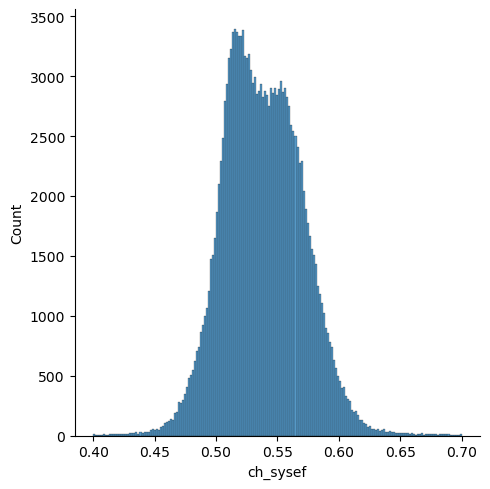

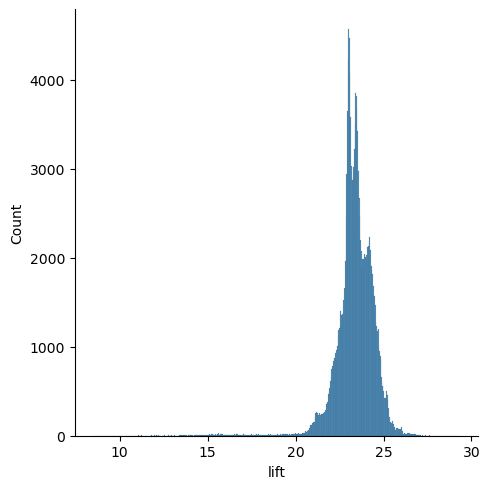

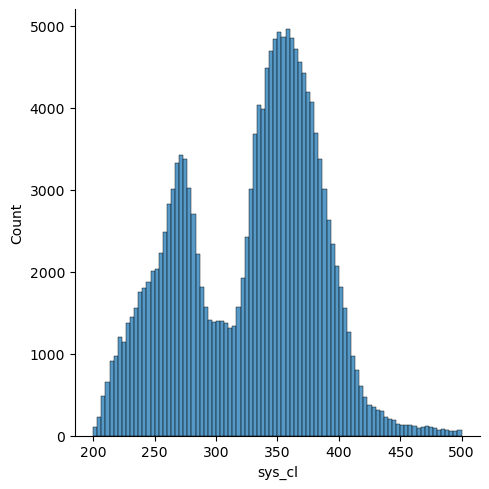

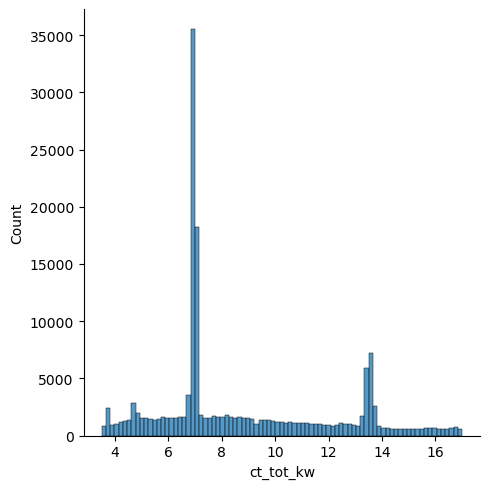

In [6]:
# distribution
sns.displot(ch_sysef_df, x="ch_sysef")
sns.displot(ch_sysef_df, x="lift")
sns.displot(ch_sysef_df, x="sys_cl")
sns.displot(ch_sysef_df, x="ct_tot_kw")

## Experiment

In [7]:
# train_test split
X = ch_sysef_df[['lift', 'sys_cl', 'ct_tot_kw']]
y = ch_sysef_df[['ch_sysef']]
y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
y.transpose()

timestamp,3/12/2023 10:43,3/12/2023 10:44,3/12/2023 10:45,3/12/2023 10:46,3/12/2023 10:47,3/12/2023 10:48,3/12/2023 10:49,3/12/2023 10:50,3/12/2023 10:51,3/12/2023 10:52,...,2/7/2024 20:00,2/7/2024 20:01,2/7/2024 20:02,2/7/2024 20:03,2/7/2024 20:04,2/7/2024 20:05,2/7/2024 20:06,2/7/2024 20:07,2/7/2024 20:08,2/7/2024 20:09
ch_sysef,0.430923,0.511065,0.51165,0.497447,0.53389,0.550988,0.570091,0.570109,0.572669,0.585907,...,0.472885,0.549562,0.545547,0.47861,0.586995,0.541987,0.511715,0.58799,0.54265,0.441344


### Random Forest Regressor

In [8]:
no_of_trees = [100, 500, 1000]
min_samples_splits = [100, 500, 1000] # maybe remove 5000 & 10000

parameter_grid = {
    'max_depth': no_of_trees,
    'min_samples_split': min_samples_splits
}

grid_search_3feat = GridSearchCV(
    estimator= RandomForestRegressor(),
    param_grid=parameter_grid,
    cv=3
)

regr = RandomForestRegressor()
grid_search_3feat.fit(X_train, y_train)

/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686:

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [100, 500, 1000],
                         'min_samples_split': [100, 500, 1000]})

In [9]:
grid_search_3feat.best_params_

{'max_depth': 500, 'min_samples_split': 100}

In [10]:
X_test.iloc[100]

lift          25.114577
sys_cl       331.823120
ct_tot_kw      9.056000
Name: 1/12/2023 17:35, dtype: float64

In [11]:
y_test.iloc[100]

ch_sysef    0.584628
Name: 1/12/2023 17:35, dtype: float64

In [12]:
grid_search_3feat.predict([[24.013, 350, 7.8]])

/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([0.56432455])

In [13]:
# simulate lift: 22-26, cl: 350 above, ct_tot_kw:7, 7.5, ...
lifts = [22, 23, 24, 25, 26]
cls = [i for i in range(250,500,50)]
ct_tot_kw = [7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5 ,12]
res = []

i = 0
for lift in lifts:
    for cl in cls:
        for ct in ct_tot_kw:
            temp_res = []
            temp_res.append(lift)
            temp_res.append(cl)
            temp_res.append(ct)
            temp_res.append(grid_search_3feat.predict([[lift, cl, ct]])[0])
            
            res.append(temp_res)

/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaco

In [14]:
df = pd.DataFrame(np.array(res), 
                  columns=['lift', 'cl', 'tot_ct_kw', 'ch_sysef'])
df

,lift,cl,tot_ct_kw,ch_sysef
0,22.0,250.0,7.0,0.524343
1,22.0,250.0,7.5,0.548214
2,22.0,250.0,8.0,0.551578
3,22.0,250.0,8.5,0.555674
4,22.0,250.0,9.0,0.557740
...,...,...,...,...
270,26.0,450.0,10.0,0.589871
271,26.0,450.0,10.5,0.585893
272,26.0,450.0,11.0,0.584572
273,26.0,450.0,11.5,0.583985


/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length

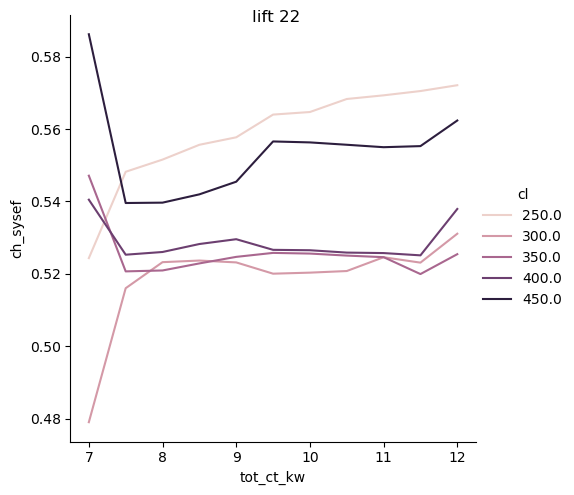

In [15]:
# graph of lift vs cooling load with hue of ct_tot_kw
p = sns.relplot(
    data=df[df['lift']==22], kind="line",
    x="tot_ct_kw", y="ch_sysef",
    hue="cl"
).fig.suptitle("lift 22")

/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length

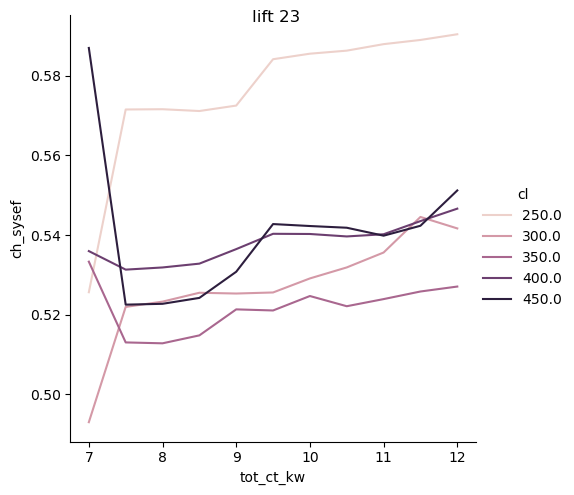

In [16]:
p = sns.relplot(
    data=df[df['lift']==23], kind="line",
    x="tot_ct_kw", y="ch_sysef",
    hue="cl"
).fig.suptitle("lift 23")

/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length

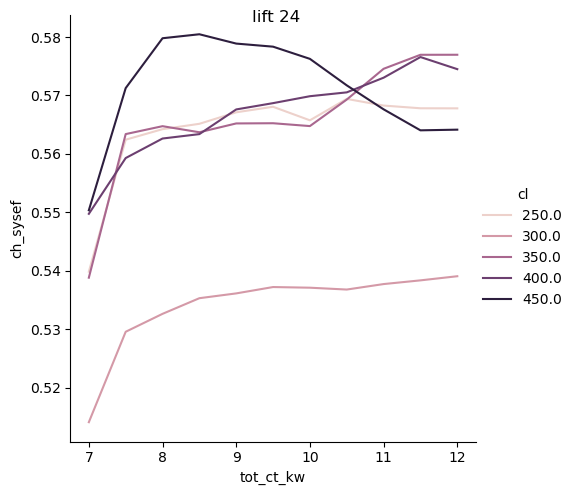

In [17]:
p = sns.relplot(
    data=df[df['lift']==24], kind="line",
    x="tot_ct_kw", y="ch_sysef",
    hue="cl"
).fig.suptitle("lift 24")

/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length

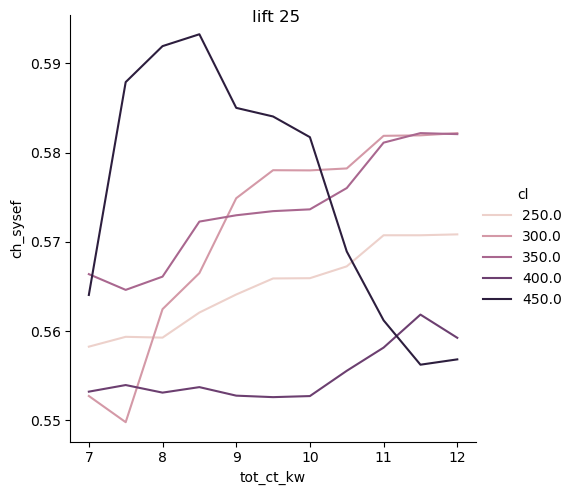

In [18]:
p = sns.relplot(
    data=df[df['lift']==25], kind="line",
    x="tot_ct_kw", y="ch_sysef",
    hue="cl"
).fig.suptitle("lift 25")

/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length

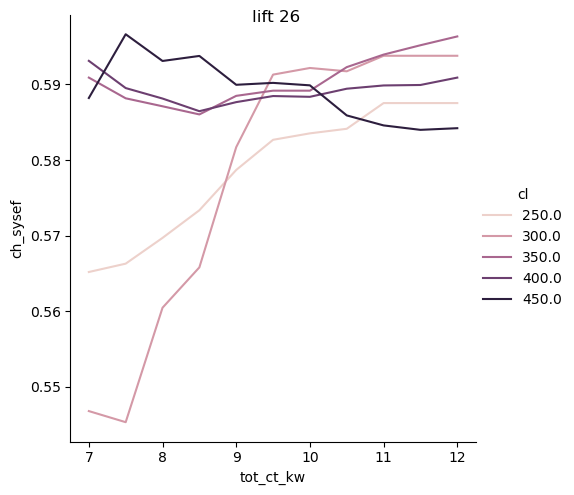

In [19]:
p = sns.relplot(
    data=df[df['lift']==26], kind="line",
    x="tot_ct_kw", y="ch_sysef",
    hue="cl"
).fig.suptitle("lift 26")

In [20]:
## save model
filename = 'random_forest_param.sav'
pickle.dump(grid_search_3feat, open(filename, 'wb'))

## Second Model

In [8]:
sec_df = fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw', 'ch_1_kwe', 'ch_2_kwe']]
sec_df.head(5)

,ch_sysef,lift,sys_cl,ct_tot_kw,ch_1_kwe,ch_2_kwe
timestamp,,,,,,
11/6/2023 9:18,0.640413,24.967691,456.382233,10.512000,159.744019,98.816010
11/6/2023 9:35,0.539539,22.572202,425.702484,15.968002,94.208015,98.304008
11/6/2023 9:36,0.545510,22.526289,418.937927,14.880002,94.208015,97.792015
11/6/2023 9:37,0.538678,22.601707,425.491486,13.824001,94.208015,98.816010
11/6/2023 9:38,0.543437,22.719701,422.201416,12.672002,95.232010,99.840012


In [9]:
len(sec_df)

67277

/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


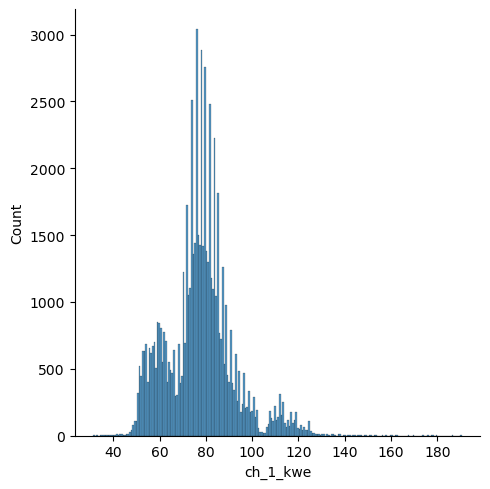

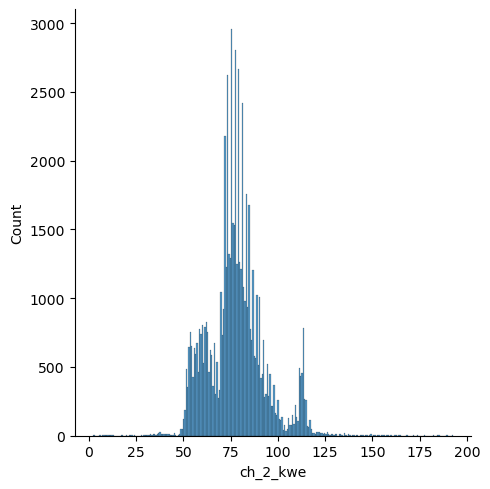

In [21]:
sns.displot(sec_df, x="ch_1_kwe")
sns.displot(sec_df, x="ch_2_kwe")

In [23]:
## train
X = sec_df[['lift', 'sys_cl', 'ct_tot_kw', 'ch_1_kwe', 'ch_2_kwe']]
y = sec_df[['ch_sysef']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2
)
y.transpose()

no_of_trees = [100, 500, 1000]
min_samples_splits = [100, 500, 1000]

parameter_grid = {
    'max_depth': no_of_trees,
    'min_samples_split': min_samples_splits
}

sec_model = GridSearchCV(
    estimator= RandomForestRegressor(),
    param_grid=parameter_grid,
    cv=5
)

sec_model.fit(X_train, y_train)

/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686:

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [100, 500, 1000],
                         'min_samples_split': [100, 500, 1000]})

In [28]:
X_test.iloc[100]

lift          22.999571
sys_cl       390.396454
ct_tot_kw     11.456000
ch_1_kwe      87.552002
ch_2_kwe      90.112007
Name: 4/10/2024 14:29, dtype: float64

In [29]:
y_test.iloc[100]

ch_sysef    0.547478
Name: 4/10/2024 14:29, dtype: float64

In [31]:
sec_model.predict([[23, 390, 11.45, 100, 90.11]])

/opt/anaconda3/envs/kaer/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([0.56154513])

In [27]:
## save
filename = 'RF_second.sav'
pickle.dump(sec_model, open(filename, 'wb'))